Process the raw Ausgrid solar data to a more usable format.<br>
Inspired by: https://github.com/pierre-haessig/ausgrid-solar-data

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Combined 3 years:
# 2010-2011 Solar home electricity data.csv
# 2011-2012 Solar home electricity data v2.csv
# 2012-2013 Solar home electricity data v2.csv
fname = 'solar.csv'

d_raw = pd.read_csv(fname, skiprows=1,
                    parse_dates=['date'], dayfirst=True,
                    na_filter=False, dtype={'Row Quality': str})

In [3]:
d_raw.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,00:30,01:00,01:30,02:00,02:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00,Row Quality
0,1,3.78,2076,GC,2010-07-01,0.303,0.471,0.083,0.121,0.361,...,0.54,0.406,0.543,0.495,0.216,0.378,0.128,0.078,0.125,
1,1,3.78,2076,CL,2010-07-01,1.250,1.244,1.256,0.744,0.019,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075,
2,1,3.78,2076,GG,2010-07-01,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,
3,1,3.78,2076,GC,2010-07-02,0.116,0.346,0.122,0.079,0.120,...,1.10,1.012,0.817,0.526,0.335,0.402,0.142,0.120,0.111,
4,1,3.78,2076,CL,2010-07-02,1.238,1.238,1.256,1.250,0.169,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.088,


#### Pick suitable customers for the Environment

In [4]:
# Group by postcode for some consistency
postcode_counts = d_raw['Postcode'].value_counts()
print("Top 5 postcodes with most samples:")
print(postcode_counts.head(5))

Top 5 postcodes with most samples:
Postcode
2259    84149
2261    55896
2290    36120
2262    23016
2093    22481
Name: count, dtype: int64


In [5]:
# Get customers in a specific postcode
postcode = 2262

d_post = d_raw[d_raw['Postcode'] == postcode].copy()
d_post_cust = d_post['Customer'].unique().tolist()
print(f"Customers in postcode {postcode}: {len(d_post_cust)}")
print(d_post_cust)

Customers in postcode 2262: 8
[10, 14, 101, 130, 168, 196, 238, 270]


In [6]:
# Print some statistics
for id in d_post_cust:
    
    d_customer = d_raw[d_raw['Customer'] == id]

    d_pv = d_customer[d_customer['Consumption Category'] == 'GG'].to_numpy()[:,5:53].flatten()
    d_d = d_customer[d_customer['Consumption Category'] == 'GC'].to_numpy()[:,5:53].flatten()

    print(f"Customer {id}")
    print(f"Generator Capacity: {d_customer['Generator Capacity'].iloc[0]} kWp")
    print(f"Average Generation: {d_pv.mean():.2f} kWh")
    print(f"Average Consumption: {d_d.mean():.2f} kWh")
    # print(d_d.shape, d_pv.shape)
    print("\n")

Customer 10
Generator Capacity: 1.05 kWp
Average Generation: 0.07 kWh
Average Consumption: 0.21 kWh


Customer 14
Generator Capacity: 1.48 kWp
Average Generation: 0.11 kWh
Average Consumption: 0.20 kWh


Customer 101
Generator Capacity: 2.04 kWp
Average Generation: 0.16 kWh
Average Consumption: 0.24 kWh


Customer 130
Generator Capacity: 1.5 kWp
Average Generation: 0.11 kWh
Average Consumption: 0.27 kWh


Customer 168
Generator Capacity: 1.1 kWp
Average Generation: 0.09 kWh
Average Consumption: 0.34 kWh


Customer 196
Generator Capacity: 1.0 kWp
Average Generation: 0.05 kWh
Average Consumption: 0.28 kWh


Customer 238
Generator Capacity: 1.5 kWp
Average Generation: 0.12 kWh
Average Consumption: 0.30 kWh


Customer 270
Generator Capacity: 1.5 kWp
Average Generation: 0.13 kWh
Average Consumption: 0.30 kWh




In [7]:
# Get big players, in search of liquidity
top_customers = d_raw.sort_values("Generator Capacity", ascending=False)["Customer"].unique()[:10]
top_capacities = [d_raw[d_raw["Customer"] == cid]["Generator Capacity"].iloc[0] for cid in top_customers]
print("Top 10 customers with highest generator capacity:")
for cid, cap in zip(top_customers, top_capacities):
    print(f"Customer {cid}: {cap} kWp")

Top 10 customers with highest generator capacity:
Customer 157: 9.99 kWp
Customer 75: 8.0 kWp
Customer 109: 6.2 kWp
Customer 289: 6.0 kWp
Customer 24: 5.9 kWp
Customer 248: 5.61 kWp
Customer 256: 4.55 kWp
Customer 152: 4.2 kWp
Customer 74: 4.04 kWp
Customer 193: 4.0 kWp


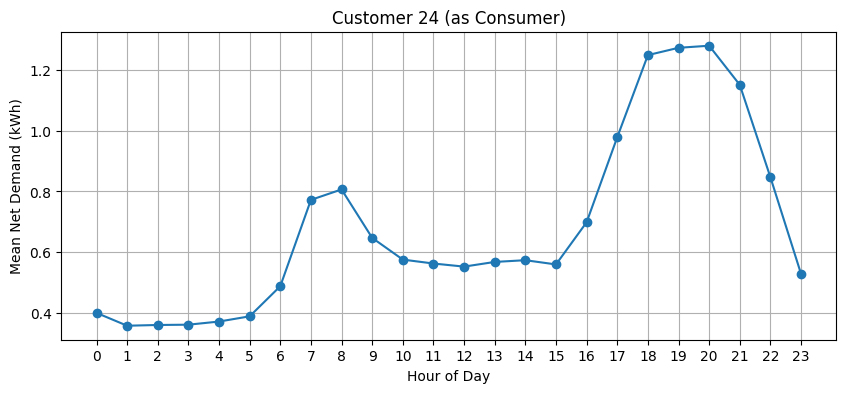

In [9]:
# Plot net demand for a specific customer
# Should aim to get prosumers that provide good liquidity
id = 24
is_prosumer = False

d_customer = d_raw[d_raw['Customer'] == id]

d_pv = d_customer[d_customer['Consumption Category'] == 'GG'].to_numpy()[:,5:53]
d_pv_hourly = d_pv.reshape(d_pv.shape[0], 24, 2).sum(axis=2).mean(axis=0)

d_d = d_customer[d_customer['Consumption Category'] == 'GC'].to_numpy()[:,5:53]
d_d_hourly = d_d.reshape(d_d.shape[0], 24, 2).sum(axis=2).mean(axis=0)

d_load = d_d_hourly - d_pv_hourly if is_prosumer else d_d_hourly

plt.figure(figsize=(10, 4))
plt.plot(range(24), d_load, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Net Demand (kWh)')
plt.title(f'Customer {id} (as {"Prosumer" if is_prosumer else "Consumer"})')
plt.grid(True)
plt.xticks(range(24))
plt.show()

#### Save processed data to a json file

In [10]:
consumers = [5, 23, 286, 292]
prosumers = [24, 74, 193, 289]

json_data = dict()

for id in sorted(consumers + prosumers):
    
    d_customer = d_raw[d_raw['Customer'] == id]

    d_pv = d_customer[d_customer['Consumption Category'] == 'GG'].to_numpy()[:,5:53].flatten()
    d_d = d_customer[d_customer['Consumption Category'] == 'GC'].to_numpy()[:,5:53].flatten()

    # Aggregate half-hourly data to hourly by summing consecutive pairs
    d_pv = d_pv.reshape(-1, 2).sum(axis=1)
    d_d = d_d.reshape(-1, 2).sum(axis=1)

    json_data[id] = {'prosumer': True if id in prosumers else False,
                     'pv_capacity': d_customer['Generator Capacity'].iloc[0],
                     'start_date': d_customer['date'].min().strftime('%d-%m-%Y'),
                     'end_date': d_customer['date'].max().strftime('%d-%m-%Y'),
                     'pv': d_pv.tolist(),
                     'demand': d_d.tolist()}

# Save to JSON file
with open('group_1.json', 'w') as f:
    json.dump(json_data, f, indent=4)